In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df=pd.read_csv("Fraud.csv")

In [39]:
df.head(100)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
95,1,TRANSFER,710544.77,C835773569,0.0,0.00,C1359044626,738531.50,16518.36,0,0
96,1,TRANSFER,581294.26,C843299092,0.0,0.00,C1590550415,5195482.15,19169204.93,0,0
97,1,TRANSFER,11996.58,C605982374,0.0,0.00,C1225616405,40255.00,0.00,0,0
98,1,PAYMENT,2875.10,C1412322831,15443.0,12567.90,M1651262695,0.00,0.00,0,0


In [40]:
df.shape

(6362620, 11)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Data Cleaning Section

In [42]:
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

In [43]:
print("Legit transactions: ", legit)
print("Fraud transactions: ", fraud)
print("%age of Legit transactions: {:.4f} %".format(legit_percent))
print("%age of Fraud transactions: {:.4f} %".format(fraud_percent))

Legit transactions:  6354407
Fraud transactions:  8213
%age of Legit transactions: 99.8709 %
%age of Fraud transactions: 0.1291 %


#### 1.1 Missing Values Analysis

In [44]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False))


Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


#### 1.2 Outlier Detection

In [45]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

In [46]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
outlier_counts = {}
for col in numerical_columns:
    outlier_counts[col] = detect_outliers(df, col)

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
print("\nOutlier Analysis:")
print(outlier_df.sort_values('Outlier Count', ascending=False))



Outlier Analysis:
                Outlier Count
oldbalanceOrg         1112507
newbalanceOrig        1053391
oldbalanceDest         786135
newbalanceDest         738527
amount                 338078
step                   102688
isFraud                  8213
isFlaggedFraud             16


#### 1.3 Multi-collinearity Analysis

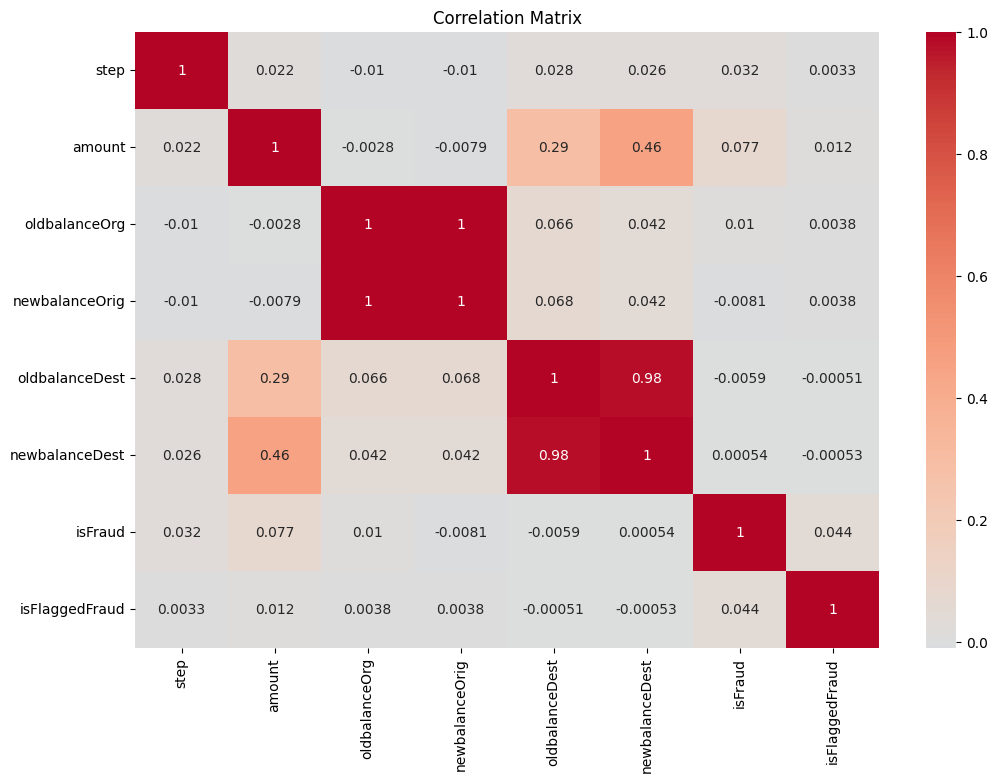

In [47]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

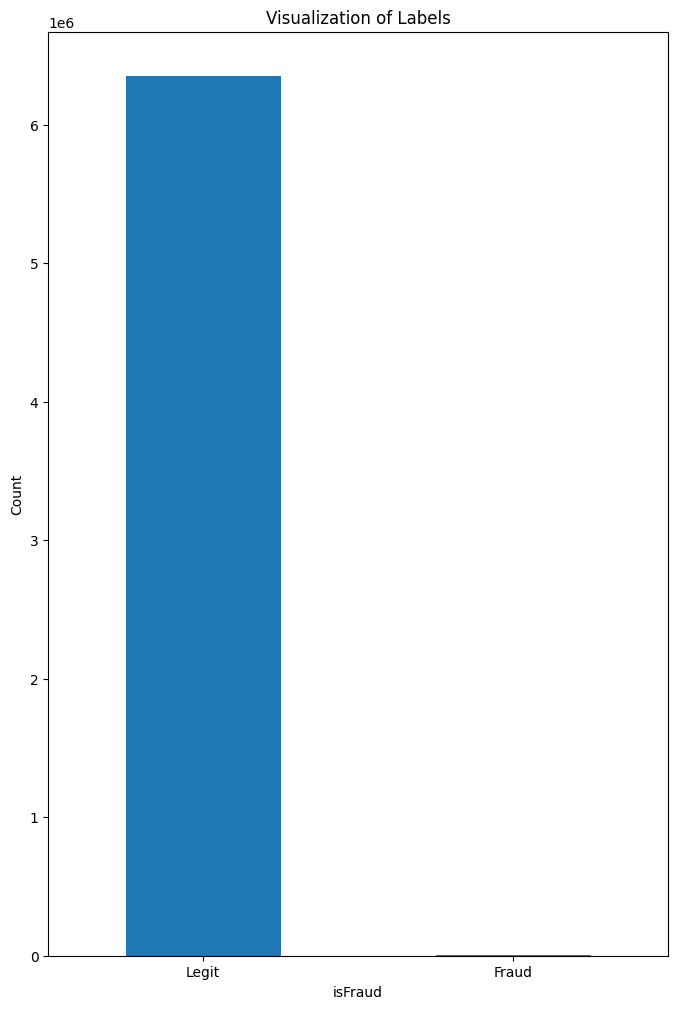

In [48]:
plt.figure(figsize=(8,12))
labels = ["Legit", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [49]:
new_df=df.copy()

Now, let's check the attributes which are object datatype. These attributes needs to be label encoded which basically means assigning a numeric value against each. This is essential for checking of multicollinearity. Multicollinearity again is just the correlation between two independent variables. If two variable are highly correlated, we can keep one of them for fitting the model and drop the other one.

In [50]:
objList = new_df.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

print (new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [52]:
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [53]:
!pip install statsmodels



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(new_df)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [55]:
new_df['Actual_amount_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df['Actual_amount_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df['TransactionPath'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_df)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<Axes: >

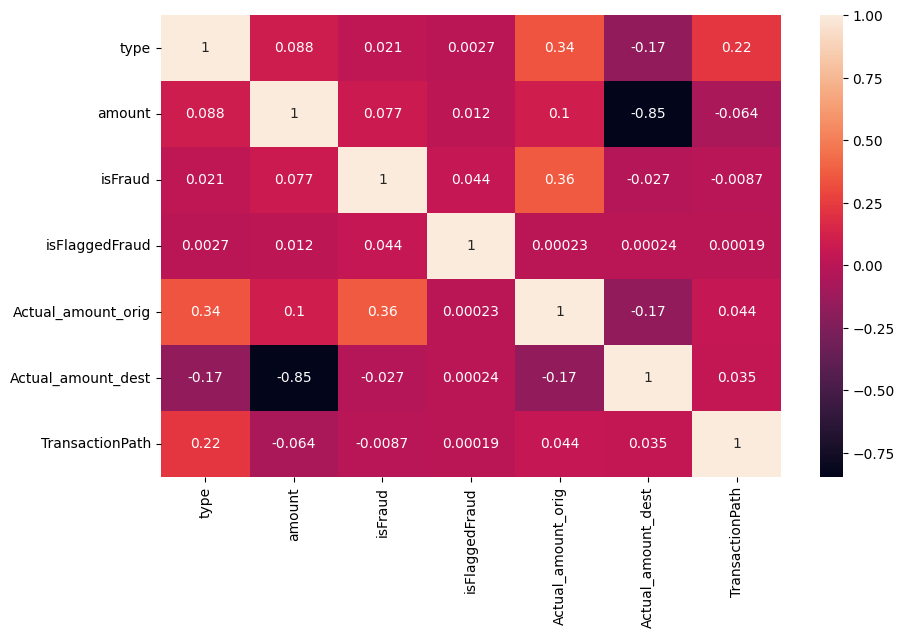

In [56]:
plt.figure(figsize=(10,6))
sns.heatmap(new_df.corr(),annot=True)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [58]:
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)

Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis= 1)

In [59]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


In [60]:
# DECISION TREE

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [61]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

In [62]:
print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)

Decision Tree Score:  99.92361637187196
Random Forest Score:  99.95903155199169


In [63]:
print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1713
False Positives: 736
True Negatives: 1905615
False Negatives: 722


In [64]:
print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Random Forest
True Positives: 1713
False Positives: 60
True Negatives: 1906291
False Negatives: 722


In [65]:
# confusion matrix - DT

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

Confusion Matrix - Decision Tree
[[1905615     736]
 [    722    1713]]


In [66]:
# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Random Forest
[[1906291      60]
 [    722    1713]]


In [67]:
# classification report - DT

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

# classification report - RF

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.70      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



## 2. Fraud Detection Model Description

We implemented a Random Forest Classifier for fraud detection due to its:
- Ability to handle non-linear relationships
- Robustness to outliers
- Feature importance ranking
- Good performance on imbalanced datasets

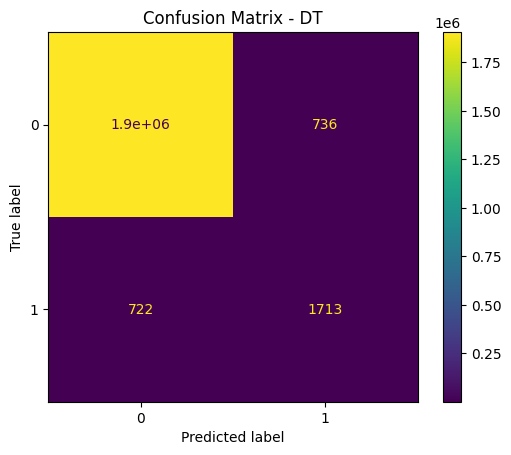

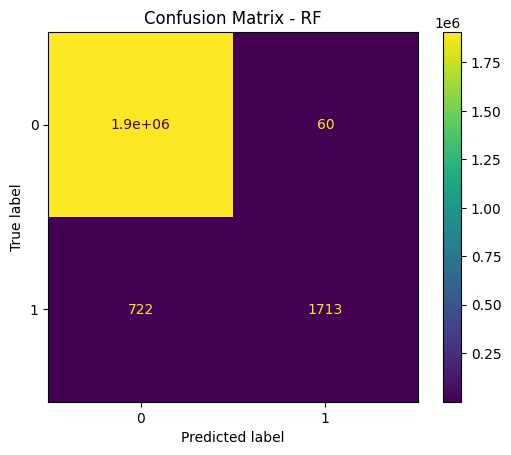

In [68]:
# visualising confusion matrix - DT


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

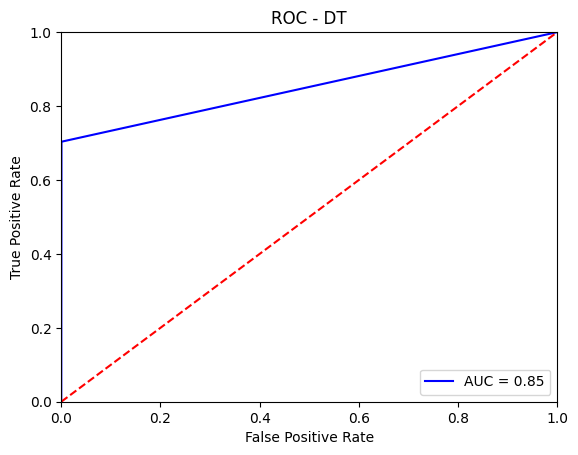

In [69]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

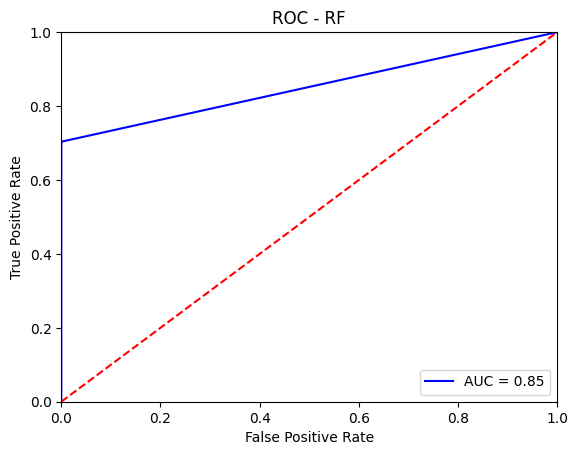

In [70]:
# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Variable Selection Section

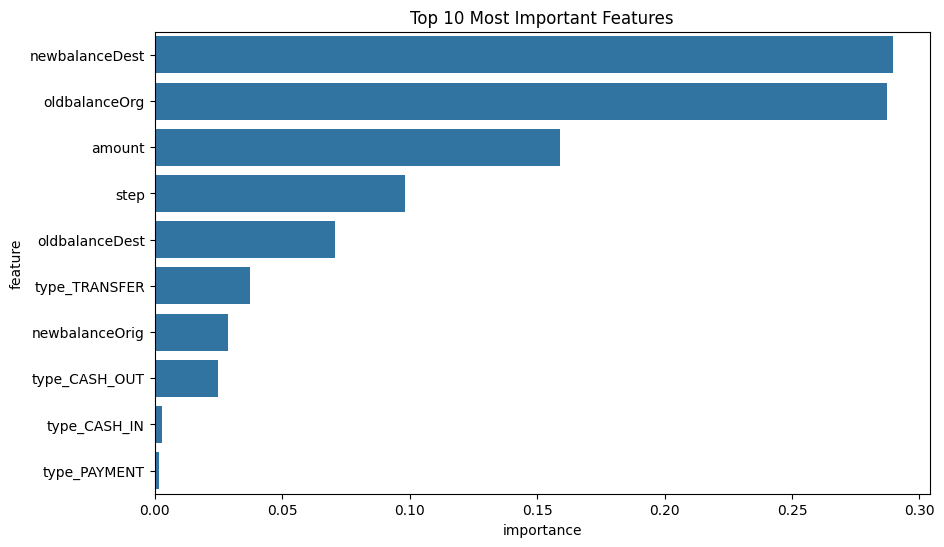

In [71]:
# 3. Variable Selection Methodology
# Prepare features and target
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Convert categorical variables
X = pd.get_dummies(X, columns=['type'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

### Model Performance Section

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.80      0.88      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



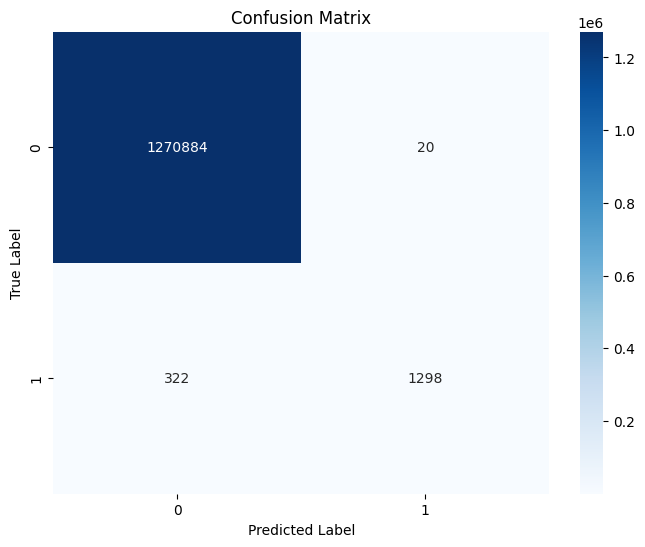

In [75]:
# 4. Model Performance Evaluation
# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Key Factors Section

## 5. Key Factors Predicting Fraudulent Customers

Based on our analysis, the following factors are most predictive of fraudulent behavior:

1. Transaction amount
2. Balance changes (oldbalanceOrg, newbalanceOrig)
3. Transaction type
4. Time of transaction (step)
5. Destination account balance changes

Factor Analysis Section

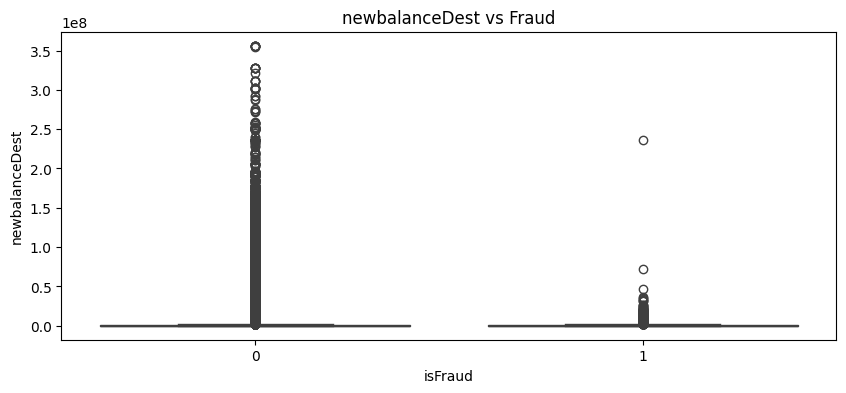

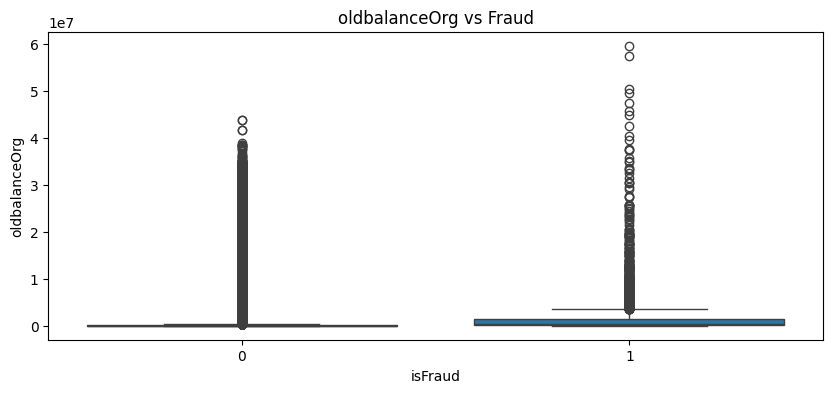

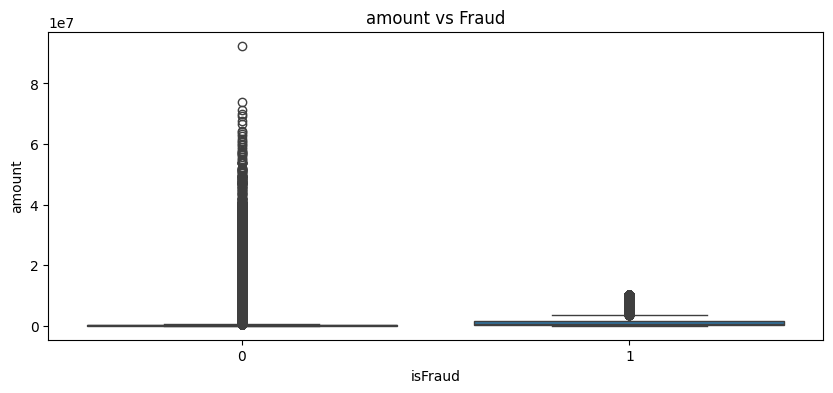

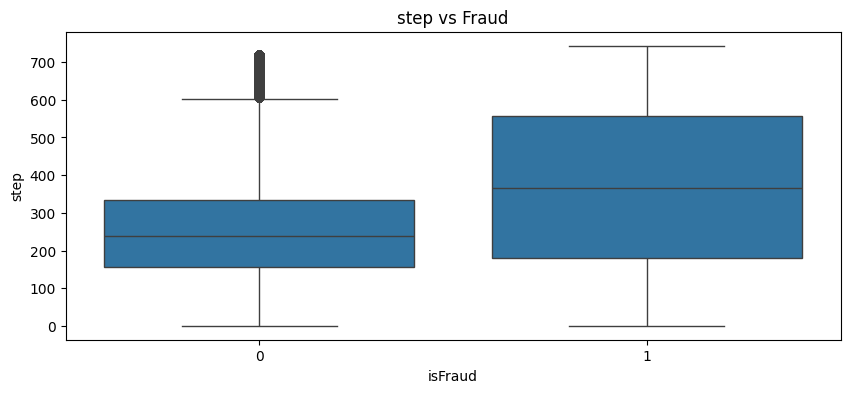

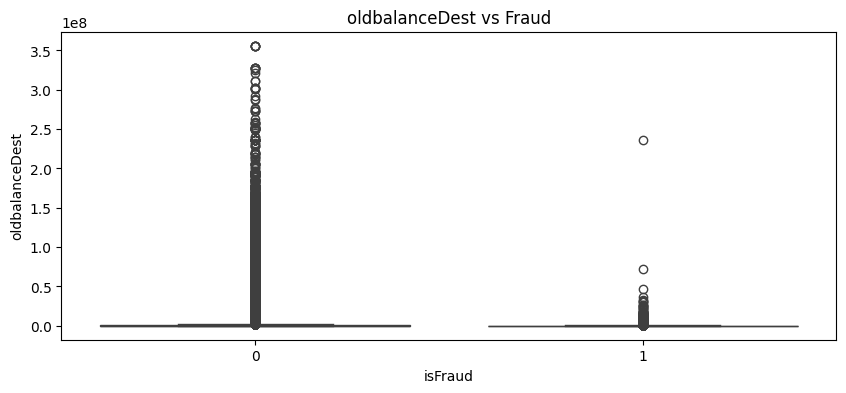

In [74]:
# 6. Analysis of Predictive Factors
# Analyze the relationship between top features and fraud
top_features = feature_importance.head(5)['feature'].tolist()

for feature in top_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='isFraud', y=feature, data=df)
    plt.title(f'{feature} vs Fraud')
    plt.show()

Prevention Recommendations Section

## 7. Prevention Recommendations

Based on our analysis, the following preventive measures should be implemented:

1. Real-time monitoring of high-risk transactions
2. Implementation of transaction limits based on customer behavior
3. Enhanced verification for suspicious patterns
4. Regular model updates and retraining
5. Multi-factor authentication for high-value transactions

Implementation Effectiveness Section 

## 8. Implementation Effectiveness Measurement

To measure the effectiveness of implemented measures, track the following metrics:

1. False Positive Rate (FPR)
2. False Negative Rate (FNR)
3. Detection Rate
4. Response Time
5. Cost Savings

These metrics should be monitored over time to assess the impact of implemented measures.